<a href="https://colab.research.google.com/github/Junhojuno/keras-tutorial/blob/master/06_RNN_Advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import auth
from google.colab import drive

auth.authenticate_user()
drive.mount('./gdrive')

In [0]:
!mkdir jena_climate

In [0]:
!cp gdrive/My\ Drive/jena_climate_2009_2016.csv.zip ./jena_climate/

In [4]:
!unzip jena_climate/jena_climate_2009_2016.csv.zip

Archive:  jena_climate/jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


## RNN 3 Advanced Skills
- Recurrent Dropout
  - RNN의 overfitting을 방지하기위해 케라스 내장 dropout을 사용
- Staking Recurrent Layer
  - 네트워크의 표현능력을 향상시킨다. (but 계산비용이 증가한다.)
- Bidirectional Recurrent Layer
  - RNN에 같은 정보를 다른 방향으로 주입하여, 정확도를 높이고 기억을 좀 더 오래 유지시킨다.

### 기온 예측 문제

In [5]:
import os

data_dir = './'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


##### 데이터 numpy로 변환

In [0]:
import numpy as np

float_data = np.zeros((len(lines),len(header) - 1)) # datetime은 빼야지
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i, :] = values

##### 시계열 온도 그래프 그리기

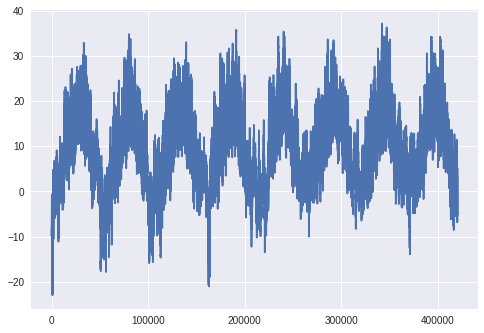

In [7]:
import matplotlib.pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.show()

##### 처음 10일간의 온도 데이터 (기간을 좀더 좁혀보자)

- 데이터가 10분마다 기록되었다. (하루 데이터는 144개겠지)

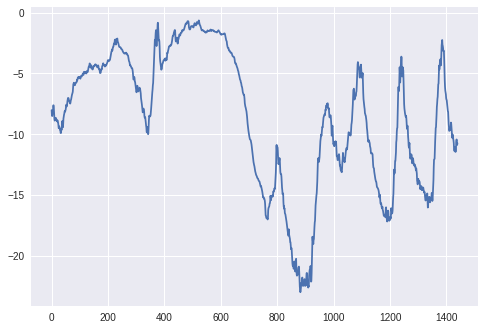

In [8]:
plt.plot(range(1440), temp[:1440])

- 마지막 3~4일정도 주기성을 보이는 듯하나...글쎄...
- 좀 불안정한데...?



### 일자별 수준의 시계열 데이터 예측
- lookback = 1440 ; 10일 전으로 돌아가 매 step의 timestep을 샘플링한다.
- steps = 6 ; 1시간마다 데이터 포인트 하나를 샘플링한다.
- delay = 144 ; 24시간 , 1일이 지난 데이터가 Target이 된다.

In [0]:
# Data Setting
# 1. 정규화
mean = float_data[:200000].mean(axis=0)
std = float_data[:200000].std(axis=0)

float_data = (float_data - mean) / std

#### Generator 함수 사용
- (samples, targets)튜플을 반복적으로 반환하는 함수 (training set)
- 이전 timestep의 데이터로 현재 timestep의 온도를 맞추는 방식
- 과거 10일의 데이터로 예측하는 데이터셋 형태를 반환하도록 한다.
- sample의 shape은 (128, 240, 14), target shape은 (128,)
- batch size=128이고, 1시간을 데이터 포인트 1개로 묶는다. 이걸 10일로 하면 240개의 데이터포인트가 나온다.


In [10]:
# Generator 함수
# 역할은 기존 데이터를 training형식에 맞도록 변환하여 반환하는 함수
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
  
  """
  data : 원본 시계열 데이터
  lookback : 입력으로 사용하기위해 거슬러 올라갈 timestep
  delay : target으로 사용할 미래의 timestep
  min/max_index : 추출할 타임스텝의 범위를 지정하기 위한 data 배열 인덱스, validation와 test 데이터 분리하는데 사용
  step : 데이터 샘플링을 할때 timestep간격, 1시간마다 데이터 포인트가 생기기 때문에 6으로 지정(데이터가 10분마다 만들어진점 고려)
  
  """
  if max_index is None:
    max_index = len(data) - delay - 1 # 왜 이렇게 정의하지?
  i = min_index + lookback
  
  while 1:
    if shuffle:
      rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
    
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)
      
    samples = np.zeros((len(rows), lookback // step, data.shape[-1])) # shape : (128, 240, 14)
    targets = np.zeros((len(rows),))
    
    for j, row in enumerate(rows): # len(rows)=128이라 128번 iteration돌것이다.
      indices = range(rows[j] - lookback, rows[j], step) # length 240의 index list가 나온다.
      samples[j] = data[indices] # initial, initial로 부터 1시간 뒤 데이터, 그로부터 또 1시간뒤 데이터.....
      targets[j] = data[rows[j] + delay][1] # 정확히 24시간뒤의 데이터
      
    yield samples, targets

print("Generator 함수 생성완료...!")

Generator 함수 생성완료...!


In [0]:
# training, validation, test 데이터
# 각각 Generator 만들자, 다만 각 generator는 다른 시간대를 사용해야한다.
# train : 처음 20만개, validation : 다음 10만개, test : 이후 나머지

lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(data=float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(data=float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(data=float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=300001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size # 전체 validation set을 순회하기 위해 val_gen 추출해야하는 횟수
test_step = (len(float_data) - 300001 - lookback) // batch_size # 전체 test set을 순회하기 위해 test_gen 추출해야하는 횟수
# 여기서 lookback은 왜 빼주지? 딱 나누어 떨어지지 않기 때문에 10일치를 미리 빼주나?

### 상식 수준의 기준점
- 아마도 오늘의 온도는 내일의 온도와 비슷할 것이다.
- 이러한 상식 기준이 있으면 추후 모델의 성능을 비교할때 좋은 척도로 활용할 수 있을 것 같다.
- 지금온도와 24시간후 온도를 같다고 해서 MAE를 계산해보자

In [0]:
def evaluate_naive_method():
  batch_maes = []
  for step in range(val_steps):
    samples, targets = next(val_gen)
    preds = samples[:,-1, 1]
    mae = np.mean(np.abs(preds - targets))
    batch_maes.append(mae)
  print(np.mean(batch_maes))
  
evaluate_naive_method()

0.2897359729905488


In [0]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393377

약 2.57도의 오차가 존재한다. (상식 수준의 기준점)

In [0]:
# 먼저 간단한 FCN으로 구해보자.
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import RMSprop

model = Sequential()
model.add(Flatten(input_shape=(lookback//step, float_data.shape[-1])))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.summary()

model.compile(optimizer=RMSprop(), loss='mae')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


In [0]:
hist = model.fit_generator(generator=train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
500/500 [==============================] - 15s 31ms/step - loss: 1.1883 - val_loss: 0.6698
Epoch 2/20
500/500 [==============================] - 14s 27ms/step - loss: 0.4594 - val_loss: 0.3433
Epoch 3/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2975 - val_loss: 0.3572
Epoch 4/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2681 - val_loss: 0.3119
Epoch 5/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2559 - val_loss: 0.3288
Epoch 6/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2477 - val_loss: 0.3125
Epoch 7/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2407 - val_loss: 0.3092
Epoch 8/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2342 - val_loss: 0.3267
Epoch 9/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2289 - val_loss: 0.3287
Epoch 10/20
500/500 [=============

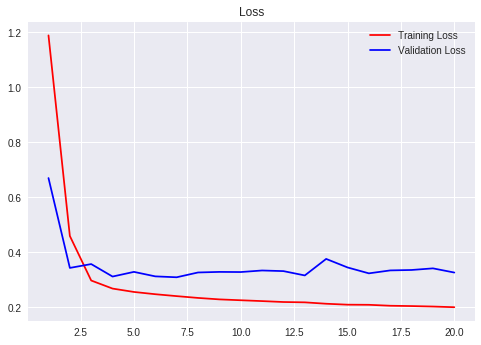

In [0]:
import matplotlib.pyplot as plt

epochs = range(1, len(hist.history['loss']) + 1)

plt.plot(epochs, hist.history['loss'], 'r-', label="Training Loss")
plt.plot(epochs, hist.history['val_loss'], 'b-', label='Validation Loss')
plt.title("Loss")
plt.legend()
plt.show()

기준점보다 못한 성능이 나왔다...

### 0.첫번째 RNN
- LSTM대신 GRU사용

In [0]:
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import RMSprop

model = Sequential()
model.add(GRU(units=32, input_shape=(lookback//step, float_data.shape[-1])))
model.add(Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


GRU 층 parameter갯수 : [(32 + 14 + 1) x 32]  x 3 = 4512

In [0]:
model.compile(optimizer=RMSprop(), loss='mae')
hist = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 312s 624ms/step - loss: 0.3105 - val_loss: 0.2697
Epoch 2/20
500/500 [==============================] - 312s 624ms/step - loss: 0.2846 - val_loss: 0.2699
Epoch 3/20
500/500 [==============================] - 312s 625ms/step - loss: 0.2785 - val_loss: 0.2670
Epoch 4/20
500/500 [==============================] - 312s 624ms/step - loss: 0.2737 - val_loss: 0.2677
Epoch 5/20
500/500 [==============================] - 312s 623ms/step - loss: 0.2673 - val_loss: 0.2668
Epoch 6/20
500/500 [==============================] - 312s 623ms/step - loss: 0.2610 - val_loss: 0.2690
Epoch 7/20
500/500 [==============================] - 313s 626ms/step - loss: 0.2563 - val_loss: 0.2672
Epoch 8/20
500/500 [==============================] - 314s 627ms/step - loss: 0.2524 - val_loss: 0.2674
Epoch 9/20
500/500 [==============================] - 314s 628ms/step - loss: 0.2475 - val_loss: 0.2716
Epoch 10/20
500/500 [==============================] - 315s 630m

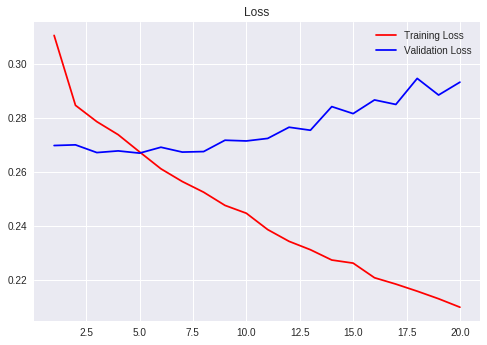

In [0]:
import matplotlib.pyplot as plt

epochs = range(1, len(hist.history['loss']) + 1)

plt.plot(epochs, hist.history['loss'], 'r-', label="Training Loss")
plt.plot(epochs, hist.history['val_loss'], 'b-', label='Validation Loss')
plt.title("Loss")
plt.legend()
plt.show()

In [0]:
min(hist.history['val_loss'])

0.2668409934327956

상식수준의 기준점보다는 감소한 것을 볼 수있다.

### RNN + Dropout
- timestep마다 동일한 dropout masking을 적용해야한다.

In [12]:
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import RMSprop

model = Sequential()
# dropout : input_t에 적용, recurrent_dropout : state_t에 적용
# timestep마다 동일한 unit을 dropout하는 대신, 
# 각 input_t와 각 state_t별로 다른 dropout masking이 적용된다.
# output_t에서의 state_t에는 dropout masking이 사용되지 않는다.
model.add(GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1]))) 
model.add(Dense(1))

model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer=RMSprop(), loss='mae')
hist = model.fit_generator(generator=train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

Instructions for updating:
Use tf.cast instead.
Epoch 1/40
500/500 [==============================] - 263s 526ms/step - loss: 0.3470 - val_loss: 0.2747
Epoch 2/40
500/500 [==============================] - 261s 522ms/step - loss: 0.3158 - val_loss: 0.2710
Epoch 3/40
500/500 [==============================] - 259s 518ms/step - loss: 0.3075 - val_loss: 0.2697
Epoch 4/40
500/500 [==============================] - 261s 522ms/step - loss: 0.3043 - val_loss: 0.2683
Epoch 5/40
500/500 [==============================] - 258s 516ms/step - loss: 0.3003 - val_loss: 0.2678
Epoch 6/40
500/500 [==============================] - 266s 533ms/step - loss: 0.2962 - val_loss: 0.2657
Epoch 7/40
500/500 [==============================] - 267s 534ms/step - loss: 0.2949 - val_loss: 0.2667
Epoch 8/40
500/500 [==============================] - 268s 536ms/step - loss: 0.2921 - val_loss: 0.2696
Epoch 9/40
500/500 [==============================] - 267s 534ms/step - loss: 0.2918 - val_loss: 0.2650
Epoch 10/40
500/

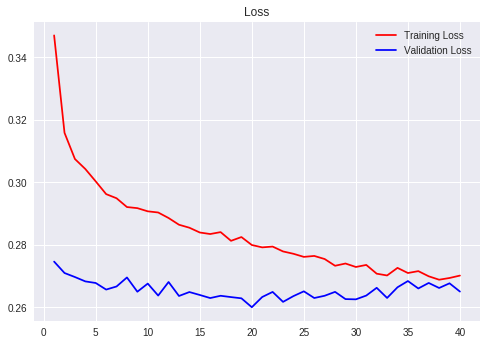

In [14]:
import matplotlib.pyplot as plt

epochs = range(1, len(hist.history['loss']) + 1)

plt.plot(epochs, hist.history['loss'], 'r-', label="Training Loss")
plt.plot(epochs, hist.history['val_loss'], 'b-', label='Validation Loss')
plt.title("Loss")
plt.legend()
plt.show()

- overfitting이 굉장히 줄어들었다!!!!!!!
- 하지만 성능은 조금? 개선